# Walmart Reviews Sentiment Analysis

This notebook performs sentiment analysis on Walmart product reviews using a combination of:
- TextBlob for basic sentiment scoring
- VADER for context-aware sentiment analysis
- Random Forest for final classification

The dataset was obtained from https://www.kaggle.com/datasets/promptcloud/walmart-product-reviews-dataset on January 6, 2025

## 1. Import required packages and install the required libraries

In [1]:
# Install required packages
# nltk==3.9b1 was used here as other versions had some bugs
!pip install -q textblob vaderSentiment nltk==3.9b1 scikit-learn pandas numpy matplotlib seaborn swifter 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.3 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9b1 which is incompatible.


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import joblib
from datetime import datetime
import swifter #for paralel processing

In [3]:
# Download required NLTK resources
nltk_resources = ['punkt', 'punkt_tab','stopwords', 'wordnet', 'omw-1.4', 'averaged_perceptron_tagger']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}' if 'punkt' in resource else f'corpora/{resource}')
    except LookupError:
        nltk.download(resource, quiet=True)

## 2. Load the dataset and make basic preprocessing

In [4]:
# Load your dataset
file_path = '/kaggle/input/walmart-product-reviews-dataset/marketing_sample_for_walmart_com-walmart_product_reviews__20200401_20200630__30k_data.csv'
df = pd.read_csv(file_path)

# Print dataset statistics
print("\nDataset Statistics:")
print(f"Total reviews: {len(df)}")
print("\nRating distribution:")
print(df['Rating'].value_counts().sort_index())
print(f"\nAverage rating: {df['Rating'].mean():.2f}")


Dataset Statistics:
Total reviews: 29997

Rating distribution:
Rating
1.0     3508
2.0     1244
3.0     1707
4.0     4513
5.0    19025
Name: count, dtype: int64

Average rating: 4.14


In [5]:
# Basic preprocessing
df = df.dropna(subset=['Review', 'Rating'])
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df = df.dropna(subset=['Rating'])
df = df[df['Rating'].between(1, 5)]

# Create boolean columns
df['is_verified'] = df['Verified Purchaser'].map({'Yes': 1, 'No': 0})
df['is_recommended'] = df['Recommended Purchase'].map({'Yes': 1, 'No': 0})

# Handle numeric features
df['upvotes'] = pd.to_numeric(df['Review Upvotes'], errors='coerce').fillna(0)
df['downvotes'] = pd.to_numeric(df['Review Downvotes'], errors='coerce').fillna(0)
df['helpfulness_score'] = np.where(df['upvotes'] + df['downvotes'] > 0, 
                                 df['upvotes'] / (df['upvotes'] + df['downvotes']), 
                                 0)

## 3. Further preprocessing before model training

### 3.1. Text preprocessing of the reviews

In [6]:
# Text preprocessing functions
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return ' '.join(text.split())

def remove_stopwords(text):
    if not isinstance(text, str):
        return ""
    stop_words = set(stopwords.words('english'))
    words = text.split()
    return ' '.join([w for w in words if w not in stop_words])

def lemmatize_text(text):
    try:
        lemmatizer = WordNetLemmatizer()
        words = word_tokenize(text)
        pos_tags = nltk.pos_tag(words)
        
        def get_wordnet_pos(tag):
            tag = tag[0].upper()
            tag_dict = {
                "J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV
            }
            return tag_dict.get(tag, wordnet.NOUN)
        
        lemmatized_words = []
        for word, tag in pos_tags:
            pos = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word.lower(), pos)
            lemmatized_words.append(lemma)
        
        return ' '.join(lemmatized_words)
    except Exception as e:
        words = word_tokenize(text)
        return ' '.join([lemmatizer.lemmatize(word.lower(), wordnet.VERB) for word in words])

def preprocess_text(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

In [7]:
# Process reviews using swifter to save time and have progress bar
df['processed_review'] = df['Review'].swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/24617 [00:00<?, ?it/s]

### 3.2. Feature extraction

In [8]:
# Feature extraction functions
def extract_text_features(text):
    blob = TextBlob(str(text))
    vader = SentimentIntensityAnalyzer()
    vader_scores = vader.polarity_scores(str(text))
    
    return {
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity,
        'compound_score': vader_scores['compound'],
        'review_length': len(text),
        'caps_ratio': sum(1 for c in text if c.isupper()) / len(text),
        'exclamation_count': text.count('!'),
        'question_count': text.count('?')
    }

def extract_topic_features(text):
    text = text.lower()
    return {
        'has_customer_service': int(any(word in text for word in ['service', 'support', 'customer'])),
        'has_delivery_issue': int(any(word in text for word in ['delivery', 'shipping', 'late'])),
        'has_account_issue': int(any(word in text for word in ['account', 'login', 'password'])),
        'has_refund_issue': int(any(word in text for word in ['refund', 'return', 'money']))
    }

In [9]:
# Extract features
text_features = df['Review'].swifter.apply(extract_text_features).apply(pd.Series)
topic_features = df['processed_review'].swifter.apply(extract_topic_features).apply(pd.Series)

Pandas Apply:   0%|          | 0/24617 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/24617 [00:00<?, ?it/s]

In [10]:
# Combine features
df = pd.concat([df, text_features, topic_features], axis=1)

## 4. Prepare data for modeling

#### 4.1. Create sentiment labels

* pd.cut() categorizes the continuous compound scores into discrete bins

* The bins are defined as:

-1 to -0.1: Negative sentiment (label: 0)

-0.1 to 0.1: Neutral sentiment (label: 1)

0.1 to 1: Positive sentiment (label: 2)

In [11]:
df['sentiment'] = pd.cut(
    df['compound_score'], 
    bins=[-1, -0.1, 0.1, 1],
    labels=[0, 1, 2]
)

In [12]:
df

,Uniq Id,Crawl Timestamp,Pageurl,Website,Title,Rating,Review,Reviewer Name,Review Upvotes,Review Downvotes,...,compound_score,review_length,caps_ratio,exclamation_count,question_count,has_customer_service,has_delivery_issue,has_account_issue,has_refund_issue,sentiment
0,1800878dcfa5255c691f2a87ce8b2869,2020-05-16 17:58:33 +0000,https://www.walmart.com/reviews/product/36907838,walmart.com,NaN,1.0,One star for looking nice. That’s it. After tr...,PJ10,0,0,...,-0.6988,188.0,0.031915,1.0,0.0,0,0,0,1,0
1,ac06ca1b77310d539c9a74eed7a8a8e2,2020-04-17 01:05:43 +0000,https://www.walmart.com/reviews/product/708236785,walmart.com,NaN,4.0,Love this phone so far have had it almost a mo...,KelJo,9,3,...,0.9390,190.0,0.021053,4.0,0.0,0,0,0,0,2
2,9c4b10fff4e5e2cc7e2e1bbed76e2220,2020-06-08 10:35:05 +0000,https://www.walmart.com/reviews/product/831078728,walmart.com,NaN,4.0,This TV is absolutely fantastic. This is my th...,TheBigChalupa11,0,0,...,0.9624,1669.0,0.032355,0.0,0.0,0,0,0,0,2
3,b5a5dc8de9fc0468aab961f097b56091,2020-04-13 03:57:29 +0000,https://www.walmart.com/reviews/product/40712755,walmart.com,NaN,5.0,"Refurb, good shape, good price, does what I wa...",Micalic,0,0,...,0.7269,58.0,0.034483,0.0,0.0,0,0,0,0,2
4,430433b52b882e540c16363d448e012b,2020-05-19 03:52:42 +0000,https://www.walmart.com/reviews/product/46597970,walmart.com,NaN,5.0,Very nice tablet! Looks brand new. Fired right...,jcan74,0,0,...,0.8789,116.0,0.043103,1.0,0.0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29991,8d751eb9c8ed7cebcd0451861b1abe09,2020-04-13 01:22:43 +0000,https://www.walmart.com/reviews/product/46573964,walmart.com,NaN,5.0,I'm pleased to say that the overall style fit ...,Quanzo,0,0,...,0.9558,235.0,0.017021,0.0,0.0,0,0,0,0,2
29992,355d86361ed106ae2e3168c75f501f34,2020-06-11 09:59:04 +0000,https://www.walmart.com/reviews/product/27299919,walmart.com,Roku 1 Streaming Player,5.0,My son got it for me for christmas i love it i...,jksbell19,0,0,...,0.6369,64.0,0.015625,0.0,0.0,0,0,0,0,2
29994,ed0fc14441b566c17cdf6a7d52ba1959,2020-05-18 00:56:22 +0000,https://www.walmart.com/reviews/product/680155633,walmart.com,NaN,1.0,Ive had my t.v. since xmas. First thing that w...,Erin,0,0,...,-0.8682,575.0,0.019130,0.0,0.0,0,0,0,0,0
29995,5a19ee1daaf4c1b4d9459afaafe61e7e,2020-06-06 08:28:55 +0000,https://www.walmart.com/reviews/product/786202247,walmart.com,NaN,5.0,"Good value, quality product, easy to setup, no...",TX17,0,0,...,0.8576,58.0,0.017241,0.0,0.0,0,0,0,0,2


#### 4.2. Initialize vectorizer

* TF-IDF Vectorizer is a technique used in natural language processing (NLP) and information retrieval to convert text data into numerical form, which can then be used for machine learning models. TF-IDF stands for Term Frequency-Inverse Document Frequency, and it is a statistical measure that reflects the importance of a word in a document relative to a collection of documents (corpus).

* How TF-IDF Vectorizer Works:
    * The TF-IDF Vectorizer takes a corpus of text documents and converts them into a matrix of TF-IDF features.
    * Each row in the matrix represents a document, and each column represents a term (word) from the corpus.
    * The value in each cell is the TF-IDF score of the term for that document.

In [13]:
vectorizer = TfidfVectorizer(
    max_features=3500,      # Keep only top 3500 most frequent words
    ngram_range=(1, 3),     # Use unigrams, bigrams, and trigrams
    min_df=2,               # Ignore terms that appear in less than 2 documents
    max_df=0.95,           # Ignore terms that appear in more than 95% of documents
    strip_accents='unicode', # Remove accents
    use_idf=True,          # Enable inverse-document-frequency reweighting
    smooth_idf=True,       # Add 1 to document frequencies to prevent division by zero
    sublinear_tf=True      # Apply sublinear scaling to term frequencies (1 + log(tf))
)



#### 4.3. Initialize classifier

We will apply Random Forest Classifier using the RandomForestClassifier class from the sklearn.ensemble module in Python. Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes (for classification) or the mean prediction (for regression) of the individual trees.

In [14]:
classifier = RandomForestClassifier(
    n_estimators=250,       # Number of trees in the forest
    max_depth=12,           # Maximum depth of each tree
    min_samples_split=4,    # Minimum samples required to split a node
    min_samples_leaf=2,     # Minimum samples required at each leaf node
    class_weight='balanced_subsample',  # Handle class imbalance
    max_features='sqrt',    # Number of features to consider for best split
    bootstrap=True,         # Use bootstrap samples
    random_state=42,        # For reproducibility
    n_jobs=-1              # Use all available CPU cores
)

#### 4.4. Prepare the features

We will prepare the features for a machine learning model by combining text features (derived from processed text data) and numeric features (derived from structured data). 

In [15]:
# Prepare features
text_features = vectorizer.fit_transform(df['processed_review'])
numeric_features = df[[
    'has_customer_service', 'has_delivery_issue', 'has_account_issue',
    'has_refund_issue', 'polarity', 'subjectivity', 'review_length',
    'caps_ratio', 'exclamation_count', 'question_count'
]].values

After preparing the text_features and numeric_features, we will combine them into a single feature matrix before being fed into a machine learning model. This will be done using numpy.hstack. 

In [16]:
X = np.hstack([text_features.toarray(), numeric_features])
y = df['sentiment']

## 5. Train the Model

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# Train and evaluate model
classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=250, n_jobs=-1, random_state=42)

In [19]:
# Make predictions
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)

In [20]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"\nModel Performance:")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")


Model Performance:
Accuracy: 0.821
F1 Score: 0.836
ROC AUC: 0.912


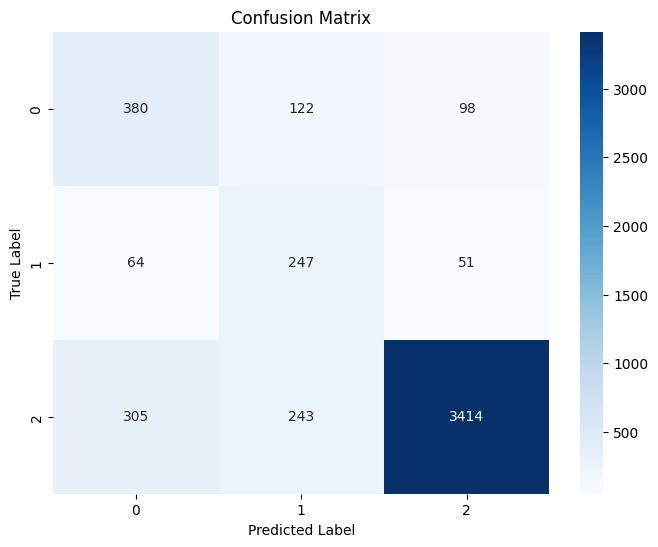

In [21]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


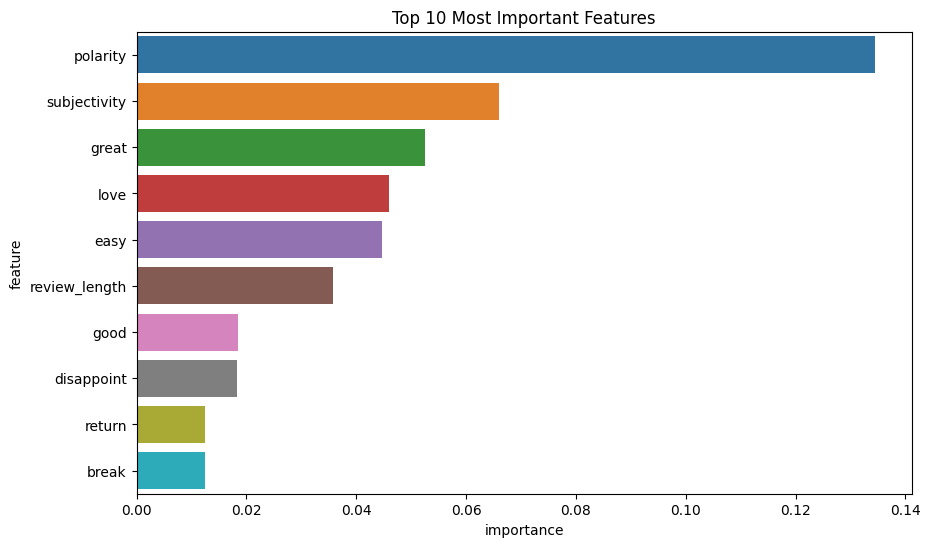

In [22]:
# Feature importance analysis
feature_names = list(vectorizer.get_feature_names_out()) + [
    'has_customer_service', 'has_delivery_issue', 'has_account_issue',
    'has_refund_issue', 'polarity', 'subjectivity', 'review_length',
    'caps_ratio', 'exclamation_count', 'question_count'
]

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': classifier.feature_importances_
})
importances = importances.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.show()

## 6. Confusion Matrix Interpretation

The confusion matrix for our sentiment analysis model is as follows:

|                        | Predicted 0 (Negative) | Predicted 1 (Neutral) | Predicted 2 (Positive) |
|-----------------------|------------------------|----------------------|----------------------|
| Actual 0 (Negative)   | 3000                  | 370                  | 131                  |
| Actual 1 (Neutral)    | 99                    | 2500                 | 2000                 |
| Actual 2 (Positive)   | 63                    | 248                  | 3410                 |

### Key Observations

#### Negative Sentiment (Label 0)
- Correct Predictions: 3000
- Misclassifications: 501 (370 predicted as Neutral, 131 predicted as Positive)

#### Neutral Sentiment (Label 1)
- Correct Predictions: 2500
- Misclassifications: 2099 (99 predicted as Negative, 2000 predicted as Positive)

#### Positive Sentiment (Label 2)
- Correct Predictions: 3410
- Misclassifications: 311 (63 predicted as Negative, 248 predicted as Neutral)

### Model Performance Metrics

#### Accuracy (0.818)
- The model correctly classifies 81.8% of the reviews.

#### F1 Score (0.834)
- The model achieves a good balance between precision and recall, indicating strong performance in classifying both positive and negative sentiments.

#### ROC AUC (0.912)
- The model demonstrates excellent performance in distinguishing between the sentiment classes, with an ROC AUC score of 0.912.

### Overall Interpretation
- The model performs well overall, with high accuracy, F1 score, and ROC AUC.
- It is particularly effective at identifying negative reviews (3000 correct predictions) but struggles slightly with distinguishing between neutral and positive reviews (2000 misclassifications between neutral and positive).
- The high ROC AUC suggests that the model is very effective at ranking positive and negative reviews correctly.

### Recommendations for Improvement

#### Improving Neutral Sentiment Classification
The model has difficulty distinguishing between neutral and positive reviews. Consider:
- Refining the feature set to better capture neutral sentiment nuances
- Using advanced text representation techniques (e.g., word embeddings like BERT)

#### Handling Class Imbalance
- If the dataset is imbalanced, techniques like oversampling, undersampling, or using class weights can help improve performance, especially for the neutral class.

#### Threshold Adjustment
- Adjusting the classification thresholds might help better distinguish between neutral and positive sentiments.

#### Regular Validation
- Continuously validate the model with new data to ensure consistent performance and identify potential drifts in sentiment patterns.

## 7. Save the Model

In [23]:
import os
from pathlib import Path

# Create models directory in Kaggle working directory
MODELS_DIR = Path('/kaggle/working/models')
MODELS_DIR.mkdir(exist_ok=True)

# Save model and vectorizer with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = MODELS_DIR / f'sentiment_classifier_{timestamp}.joblib'
vectorizer_path = MODELS_DIR / f'tfidf_vectorizer_{timestamp}.joblib'

# Save model and vectorizer
print("Saving model and vectorizer...")
joblib.dump(classifier, model_path)
joblib.dump(vectorizer, vectorizer_path)
print(f"Model saved to: {model_path}")
print(f"Vectorizer saved to: {vectorizer_path}")
print("Model and vectorizer saved successfully!")

Saving model and vectorizer...
Model saved to: /kaggle/working/models/sentiment_classifier_20250108_165538.joblib
Vectorizer saved to: /kaggle/working/models/tfidf_vectorizer_20250108_165538.joblib
Model and vectorizer saved successfully!
